In [1]:
import quickage
import warnings
warnings.filterwarnings("ignore")

import astropy.coordinates as astro_coord
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
#from astropy.constants im
%matplotlib inline
import pandas as pd

In [24]:
def draw_random_star(select_by= ['metallicity', 'velocity', 'jz'], dataset='galah', nsample=1,\
                     nsigma=1, norbits=50, volume=10, velocity_volume=50):
    
    #draw a random star
    df= quickage.load_schneider_samples().sample(n=nsample).reset_index(drop=True)
    
    res_df=[]
    for index, row in df.iterrows():
        try:
            dist= 1000/np.random.normal(row.plx,row.eplx,  1000)

            sourc={'ra': row.ra_gaia, \
                      'dec': row.de_gaia,
                      'pmra':( row.pmracosdec, np.abs(0.1*row.pmracosdec)),
                      'pmdec':(row.pmde,  np.abs(0.1*row.pmde)),
                      'distance': (np.nanmedian(dist), np.nanstd(dist)),
                      'rv':(row['rv'], 0.1*np.abs(row['rv']))}
            metal=(row['[Fe/H]'] , np.abs(0.1*row['[Fe/H]']))

            res=quickage.estimate_age(sourc, metal, nsigma=nsigma, data_set=dataset, select_by=select_by, 
                                      norbits= norbits, volume=volume, velocity_volume=velocity_volume)
            
            med=res['median_age']
            unc=list(res['std_age'])

            res_df.append({'real': row.age1,
                           'real_unc': [row.l_age1, row.u_age1],
                   'res_median': med ,
                    'res_unc': unc})
        except:
            pass
    return pd.DataFrame.from_records(res_df)
 

In [3]:
ross={'ra': 34.76599999999999,
              'dec':35.353388888888894,
              'pmra':(670.532, 0.042),
              'pmdec':( -427.412, 0.040),
              'distance':  (17.44, 0.012),
              'rv': (-27.80, 0.14)}

ross_metal= (-0.40, 0.12)

ross_age= (7.2, 3.7)

trapp={'ra': 346.6250957,
              'dec':-5.0428081,
              'pmra': (922.0 , 0.6),
              'pmdec': (-471.9, 0.9),
              'distance':  (12.49 , 0.18),
              'rv': (-51.688, 0.014)}
trapp_metal=(0.04 , 0.08)

trapp_age= (7.6, 2.2)

trapp_res=quickage.estimate_age(trapp, trapp_metal, nsigma=1, data_set='galah', \
                                select_by=['metallicity'], norbits=200, velocity_volume=100)
 
ross_res=quickage.estimate_age(ross, ross_metal, nsigma=3, data_set='galah',\
                               select_by=['metallicity'],  norbits=200, velocity_volume=100)

In [4]:
#ross_res=quickage.estimate_age(ross, ross_metal, nsigma=3,  volume=100,
#                             data_set='galah',select_by=['velocity', 'metallicity'],  norbits=200)

In [5]:
ross_res

{'median_age': 7.1672378130601695,
 'std_age': (3.4818570099339454, 2.714533156897983),
 'posterior': array([11.99275935,  9.77413525,  6.40225386, ...,  7.34777727,
         8.21051822,  3.49361115])}

In [40]:
x= draw_random_star(select_by=['metallicity'], \
                    volume=30,   velocity_volume=10, dataset='galah', nsample=1000, nsigma=3, 
                    norbits=1000)

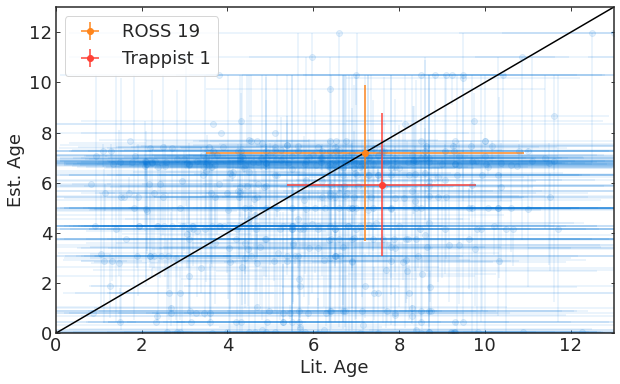

In [41]:
fig, ax=plt.subplots(figsize=(10, 6))



yerr=np.vstack(x['res_unc'].values).T
ax.errorbar(x['real'], x['res_median'], xerr=np.abs(np.vstack(x.real_unc.values).T-x.real.values), \
            yerr=yerr,  fmt='o', c='#0074D9', ecolor = '#0074D9', alpha=0.1)


ax.errorbar(ross_age[0], ross_res['median_age'], xerr= ross_age[1], yerr= np.array([ross_res['std_age']]).T,\
            fmt='o', c='#FF851B', ecolor = '#FF851B', label='ROSS 19')

ax.errorbar(trapp_age[0], trapp_res['median_age'], xerr= trapp_age[1], yerr= np.array([trapp_res['std_age']]).T,\
            fmt='o', c='#FF4136', ecolor = '#FF4136', label='Trappist 1')

ax.legend()
ax.plot([0., 13], [0, 13], c='k')
ax.set(xlim=[0, 13], ylim=[0, 13])
ax.set(xlabel='Lit. Age', ylabel='Est. Age')
plt.savefig('unweighted_ages_metcuts.jpeg')